### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math
import sys
sys.path.append('../../')
from pprint import pprint
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle
seed = 42
np.random.seed(seed)

In [2]:
# analyticalResult = sin^2(θ)
# θ = arcsin(sqrt(analyticalResult))
b_max = math.pi / 500  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2 ** nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5)) ** 2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

print("theoretical theta: ", np.arcsin(np.sqrt(analyticResult)))

Analytical Result: 1.315936863217701e-05
Discretized Result: 1.3159365494765862e-05
theoretical theta:  0.0036275923634797222


In [3]:
from qiskit import QuantumRegister
from qiskit import execute
from qiskit import Aer
from scipy import optimize
from lib_grover import *

In [4]:
#setting the number of shots and Grover operators.
max_iter = 10
number_grover_list = [1, 2, 4, 8, 16, 32, 64]  # list of number of Grover operators
shots = 8192
shots_list = [shots] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception('The length of shots_list should be equal to the length eof number_grover_list.')

backend = Aer.get_backend('qasm_simulator')

In [5]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [6]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
from lib_grover import *
noise_model = None

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.990, 0.010],[0.010,0.990]])
        noise_model.add_readout_error(read_err, [qi])

In [8]:
t1 = time.perf_counter()
raw_hist_list_list = []
for i in range(max_iter): # set the seed as index i
    sys.stdout.write("\ntry=(%d/%d)\r" % ((i + 1), max_iter))
    raw_hist_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model, seed_transpiler=i, seed_simulator=i)  # list of number of grover operators
    raw_hist_list_list.append(raw_hist_list)
    sys.stdout.flush()
t2 = time.perf_counter()
print("\n\n", t2 - t1, "s")


iter=(7/7)
iter=(7/7)
iter=(7/7)
iter=(7/7)
iter=(7/7)
iter=(7/7)
iter=(7/7)
iter=(7/7)
iter=(7/7)
iter=(7/7))

 109.51515229099999 s


In [9]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
meas_fitters = []
for i in range(max_iter):
    job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model, seed_transpiler=i, seed_simulator=i)
    cal_results = job.result()
    meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)
    meas_fitters.append(meas_fitter)
    print("iter", i, "finished")

iter 0 finished
iter 1 finished
iter 2 finished
iter 3 finished
iter 4 finished
iter 5 finished
iter 6 finished
iter 7 finished
iter 8 finished
iter 9 finished


In [10]:
with open("pkls/raw_hist_list_list.pkl", "wb") as f:
    pickle.dump(raw_hist_list_list, f)

In [11]:
with open("pkls/meas_fitters.pkl", "wb") as f:
    pickle.dump(meas_fitters, f)

# test

In [12]:
raw_hit_list_list = []
for i in range(max_iter):
    raw_hit_list_list.append( make_hit_list(raw_hist_list_list[i]) )
    print("iter", i + 1, "finished")

iter 1 finished
iter 2 finished
iter 3 finished
iter 4 finished
iter 5 finished
iter 6 finished
iter 7 finished
iter 8 finished
iter 9 finished
iter 10 finished


Text(0, 0.5, 'number of shots for $|00...0>$')

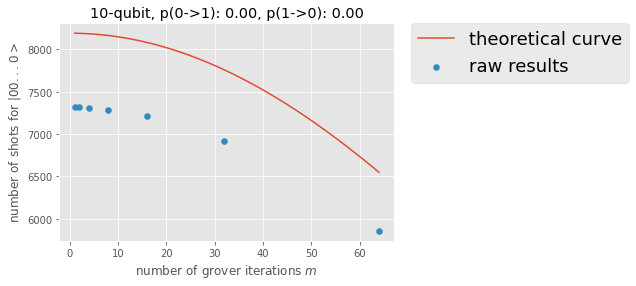

In [13]:
divide = len(number_grover_list)
plt.plot(np.linspace(number_grover_list[0], number_grover_list[-1], 100), 
         shots * np.cos(2 * np.linspace(number_grover_list[0], number_grover_list[-1], 100) * np.arcsin(np.sqrt(discretizedResult))) ** 2, 
         label="theoretical curve", color="C0") # resolved, 2021.12.27
plt.scatter(number_grover_list, raw_hit_list_list[-1], marker="o", label="raw results", color="C1")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("10-qubit, p(0->1): 0.01, p(1->0): 0.01")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [14]:
thetaCandidate_raw_list_list = []
for iter_count, raw_hit_list in enumerate(raw_hit_list_list):
    thetaCandidate_raw_list_list.append( calculate_theta(raw_hit_list, number_grover_list, shots_list) )
    print("iter", iter_count + 1, "finished")

/Users/yangbo/Documents/projects/master_thesis/test_libs_qrem/modified_grover/n10_piover500/p001_q001/../../lib_grover.py:224: RuntimeWarning: invalid value encountered in sqrt
  theta = np.arcsin(np.sqrt(p))


iter 1 finished
iter 2 finished
iter 3 finished
iter 4 finished
iter 5 finished
iter 6 finished
iter 7 finished
iter 8 finished
iter 9 finished
iter 10 finished


In [16]:
error_raw_list = np.zeros_like(number_grover_list,dtype=float)
error_raw_list_list = [np.zeros_like(number_grover_list,dtype=float)]
for thetaCandidate_raw_list in thetaCandidate_raw_list_list:
    error_raw_list += (np.sin(thetaCandidate_raw_list)**2 - discretizedResult)**2  # list of estimation errors
    error_raw_list_list.append(np.sin(thetaCandidate_raw_list)**2 - discretizedResult)
error_raw_list = ( error_raw_list / (max_iter - 1) ) ** (1 / 2)

In [17]:
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append( CalcNumberOracleCalls(i, shots_list, number_grover_list) )
    ErrorCramérRao_list.append( CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list) )

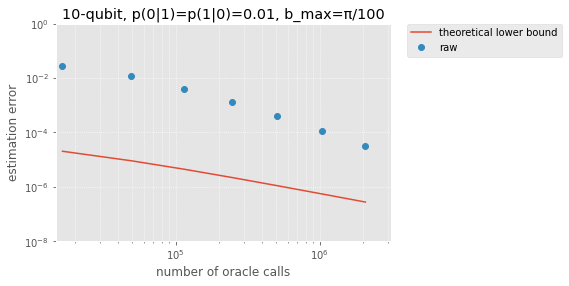

In [18]:
plt.clf()
plt.style.use('ggplot')
p_theoretical = plt.loglog( OracleCall_list, ErrorCramérRao_list, color='C0')
p_raw = plt.loglog( OracleCall_list, error_raw_list, 'o', color='C1', markersize=6)

plt.title("10-qubit, p(0|1)=p(1|0)=0.01, b_max=π/500")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("estimation error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p_theoretical[0], p_raw[0]), 
           ("theoretical lower bound", "raw"),
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)